### Edgar Moises Hernandez-Gonzalez
#### 26/07/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFT (3D)
##### Entrada de 90x17
##### Validacion cruzada

In [1]:
from google.colab import drive

In [47]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None).iloc[:, 0:768]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None).iloc[:, 1536:2304]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None).iloc[:, 0:768]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None).iloc[:, 1536:2304]

In [6]:
x_train = pd.concat([c3_train, c4_train], axis=1)
x_test = pd.concat([c3_test, c4_test], axis=1)

In [7]:
# x_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None)
# x_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_train.csv", header=None).values
y_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_test.csv", header=None).values

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 1536)
(140, 1536)
(140, 1)
(140, 1)


In [9]:
x = pd.concat([x_train, x_test])
y = np.concatenate((y_train, y_test))

In [10]:
print(x.shape)
print(y.shape)

(280, 1536)
(280, 1)


In [11]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 280


In [12]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [13]:
#unir 2 canales y 3 segundos
def unir_espectrogramas_vertical(data):
  fs = 128
  datos = np.zeros((data.shape[0],90,17))
  temporal = np.zeros((90,17))
  for i in range(data.shape[0]): #n muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*768:(j+1)*768]
      sig = sig[32:416]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=128, window='hann', nperseg=128,
                              noverlap=112, nfft=256, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [14]:
#llamar a unir_espectrogramas_vertical_resize(data)
inicio = time.time()

x = unir_espectrogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
Tiempo: 0.6224105358123779


In [15]:
print(x.shape)

(280, 90, 17)


In [16]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.009925350444004888
6.89847106360668e-12
9.56369384998064e-05


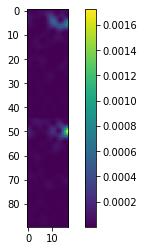

In [17]:
plt.figure()
plt.imshow(x[1])
plt.colorbar()
plt.show()

In [18]:
#convertir de 3D a 4D
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

print(x.shape)

(280, 90, 17, 1)


In [19]:
skf = StratifiedKFold(n_splits = 5)

In [20]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(64, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  0.2890032061508724
accuracy:  0.875
confusion matrix:
 [[26  2]
 [ 5 23]]


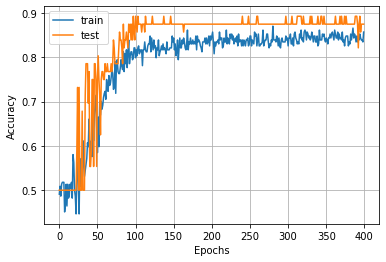

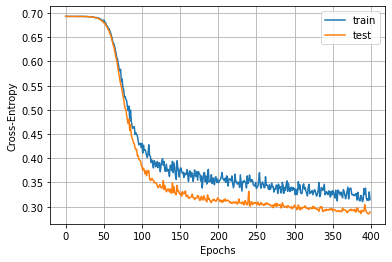


Iteration: 2
loss:  0.24549773335456848
accuracy:  0.9285714030265808
confusion matrix:
 [[27  1]
 [ 3 25]]


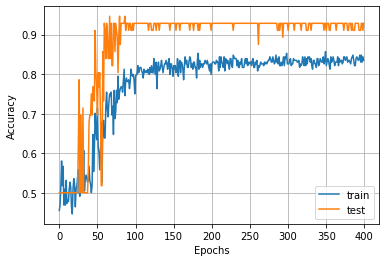

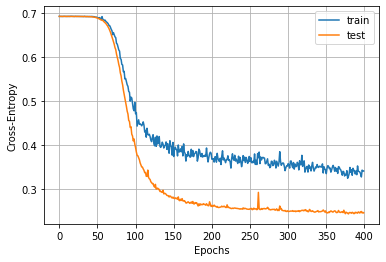


Iteration: 3
loss:  0.5777907967567444
accuracy:  0.75
confusion matrix:
 [[20  8]
 [ 6 22]]


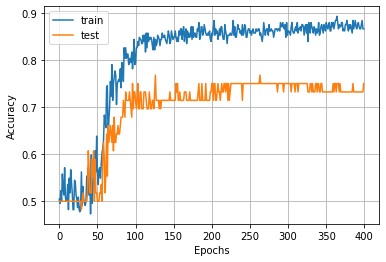

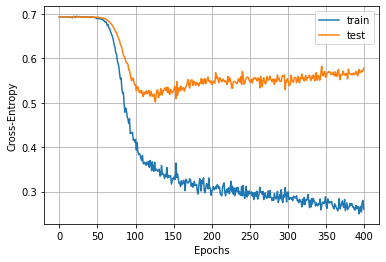


Iteration: 4
loss:  0.3338325023651123
accuracy:  0.8571428656578064
confusion matrix:
 [[23  5]
 [ 3 25]]


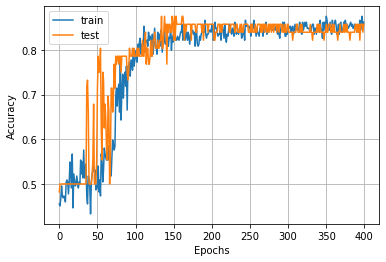

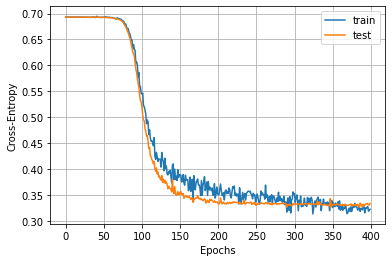


Iteration: 5
loss:  0.5137712189129421
accuracy:  0.75
confusion matrix:
 [[25  3]
 [11 17]]


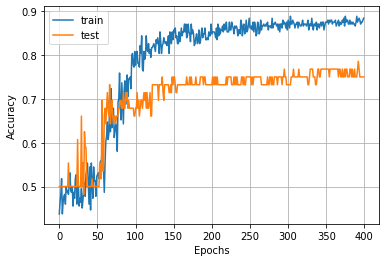

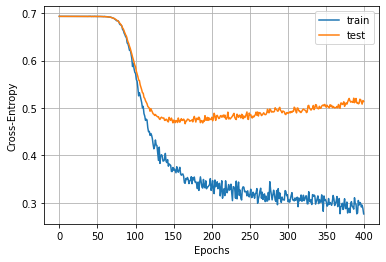


Resultados:
loss: [0.2890032061508724, 0.24549773335456848, 0.5777907967567444, 0.3338325023651123, 0.5137712189129421]
accuracy: [0.875, 0.9285714030265808, 0.75, 0.8571428656578064, 0.75]
Tiempo: 295.1716904640198


In [43]:
inicio = time.time()
array_loss = []
array_acc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=400, batch_size=16,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [44]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 90, 17, 64)        640       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 45, 8, 64)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 45, 8, 64)         36928     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 22, 4, 64)         0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 5632)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)               721024    
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)             

In [45]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.8321
std: (+/- 0.0711)
Max Accuracy: 0.9286
Tiempo: 295


In [46]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul 27 04:25:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    64W / 149W |    873MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------